In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

import cubnm
import cubnm_paper

# set plots font and dpi
# Note: the font is not included in the repository
import matplotlib.font_manager
font_path = os.path.join(cubnm_paper.config.DATA_DIR, 'assets', 'Optima.ttc')
matplotlib.font_manager.fontManager.addfont(font_path)
font = matplotlib.font_manager.FontProperties(fname=font_path, size=12)
plt.rcParams.update({
    "font.family": font.get_name(),
    "figure.dpi": 600
})

thcolor = '#44546A'

# Load session-specific heritability estimates

Output CSVs (`output.csv`) have been calculated and created via `scripts/heritability/calculate_h2.py`.
Here we load them and convert them to a long dataframe:

In [2]:
h2s_ses = {}
h2s_long_ses = {}

for i, ses in enumerate(['REST1_LR', 'REST2_LR']):
    h2s_ses[ses] = {}
    h2s_long_ses[ses] = {}
    SOLAR_ROOT = os.path.join(
        cubnm_paper.config.DATA_DIR, 'hcp', 
        'solar', ses
    )
    for analysis in sorted(os.listdir(SOLAR_ROOT)):
        solar_out = pd.read_csv(
            os.path.join(SOLAR_ROOT, analysis, 'output.csv'),
            index_col = 0
        )
        # drop duplicate rows (last index is duplicated in solar output)
        solar_out = solar_out.loc[~solar_out.index.duplicated(keep='first')]
        # drop node- or edge- prefix
        if (
            solar_out.index[0].startswith('node')
            or solar_out.index[0].startswith('edge')
        ):
            solar_out.index = solar_out.index.map(lambda s: int(s.replace('node_','').replace('edge_','')))
        # sort by index
        solar_out = solar_out.sort_index()

        h2s_ses[ses][analysis] = solar_out
        
        # convert to long
        h2s_long_ses[ses] = []
        for k, h2_df in h2s_ses[ses].items():
            if k.endswith('edge'):
                category = 'edge'
            elif k.endswith('strength'):
                category = 'strength'
            elif k.endswith('_I') or k.endswith('_E'):
                category = 'state'
            else:
                category = 'param'
            if category == 'param':
                for param in h2_df.index:
                    h2s_long_ses[ses].append({
                        'empirical': False,
                        'sc': False,
                        'category': category,
                        'what': param,
                        'index': np.nan,
                        'h2': h2_df.loc[param, 'h2r']
                    })
            else:
                for i in range(h2_df.shape[0]):
                    h2s_long_ses[ses].append({
                        'empirical': ('emp' in k) or (k.startswith('sc')),
                        'sc': k.startswith('sc'),
                        'category': category,
                        'what': k,
                        'index': i,
                        'h2': h2_df['h2r'].values[i]
                    })

        h2s_long_ses[ses] = pd.DataFrame(h2s_long_ses[ses])

In [5]:
h2s_long_ses

{'REST1_LR':       empirical     sc  category             what  index        h2
 0         False  False     state              I_E    0.0  0.248520
 1         False  False     state              I_E    1.0  0.219481
 2         False  False     state              I_E    2.0  0.317678
 3         False  False     state              I_E    3.0  0.254171
 4         False  False     state              I_E    4.0  0.310367
 ...         ...    ...       ...              ...    ...       ...
 8260      False  False  strength  sim_fc_strength   95.0  0.218552
 8261      False  False  strength  sim_fc_strength   96.0  0.152527
 8262      False  False  strength  sim_fc_strength   97.0  0.265684
 8263      False  False  strength  sim_fc_strength   98.0  0.226872
 8264      False  False  strength  sim_fc_strength   99.0  0.285652
 
 [8265 rows x 6 columns],
 'REST2_LR':       empirical     sc  category             what  index        h2
 0         False  False     state              I_E    0.0  0.195

# Plot

/tmp/ipykernel_29988/451362814.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_29988/451362814.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_29988/451362814.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_29988/451362814.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_29988/451362814.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_29988/451362814.py:136: UserWarning: set

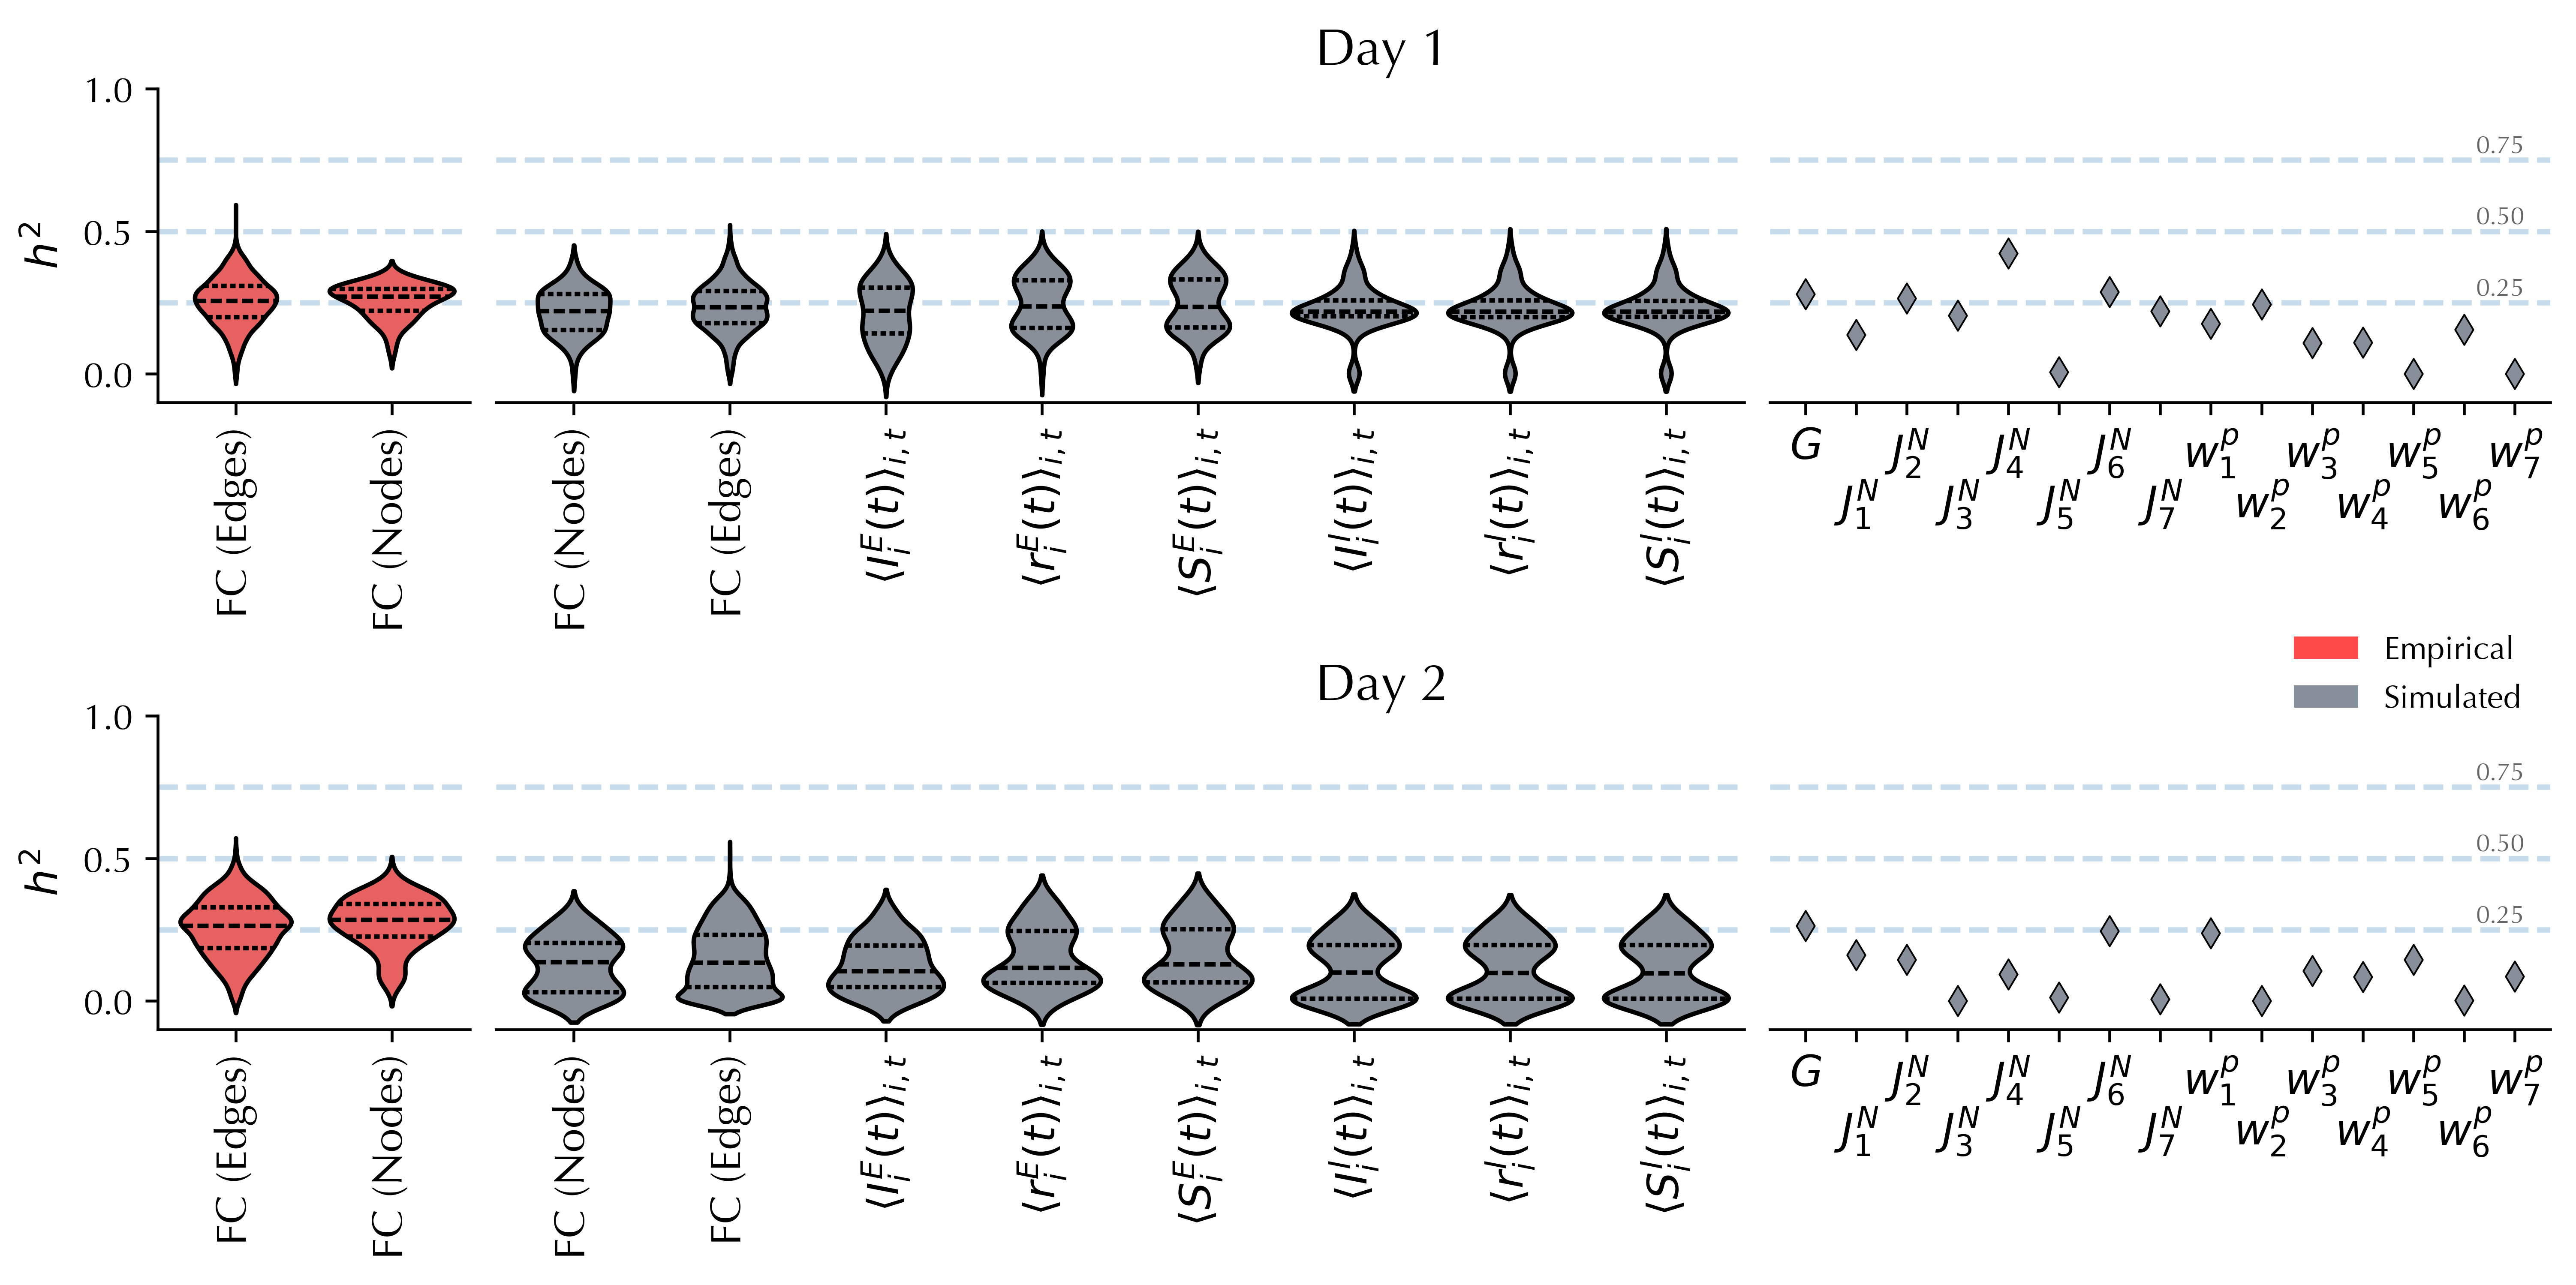

In [6]:
### Settings ###
alpha = 1.0 # to make sure the indicator lines are behind everything else
emp_color = '#ff4a4a' # looks similar to red + alpha = 0.65
sim_color = '#878f9a'
linecolor = 'black'
width = 0.8
ticklabel_rotation = 90
fontsize=12

### Labels ###
labels = {
    'sim_fc_edge': 'FC (Edges)',
    'emp_fc_edge': 'FC (Edges)',
    'sim_fc_strength': 'FC (Nodes)',
    'emp_fc_strength': 'FC (Nodes)',
    'sc_edge': 'SC (Edges)',
    'sc_strength': 'SC (Nodes)'
}
state_vars = ['I_E', 'r_E', 'S_E', 'I_I', 'r_I', 'S_I']
for var in state_vars:
    state_var, neuron = var.split('_')
    labels[var] = r'$\langle '+state_var+r'^'+neuron+r'_i(t) \rangle_{i,t}$'
params = h2s_long_ses['REST1_LR'].loc[(h2s_long_ses['REST1_LR']['category']=='param'), 'what'].values
for i, param in enumerate(params):
    if '_' in param:
        # w_p and J_N
        labels[param] = r'$'+param[0]+r'_'+str(int(param[-1])+1)+r'^'+param[2]+r'$'
    else:
        # G
        labels[param] = r'$'+param+r'$'
    # put every other parameter after a newline to space them better
    if (i+1)%2==0:
        labels[param] = '\n'+labels[param]
    

fig, axd = plt.subplot_mosaic(
    [
        ["emp_fc_1",  "space0_1",  "sim_1",     "space1_1", "params_1"],
        ["emp_fc_2",  "space0_2",  "sim_2",     "space1_2", "params_2"]
    ],
    width_ratios=[0.6, 0.05, 2.4, 0.05, 1.5],
    figsize=(12, 4.75),
)

for day in ['1', '2']: 
    ses = f"REST{day}_LR"
    ### H2 empirical FC ###
    ax = axd[f"emp_fc_{day}"]
    plot_data = h2s_long_ses[ses].loc[
        h2s_long_ses[ses]['empirical'] & ~h2s_long_ses[ses]['sc']
    ]
    sns.violinplot(
        data=plot_data, 
        x='what', 
        y='h2',
        order=[
            'emp_fc_edge', 'emp_fc_strength', 
        ],
        color=emp_color,
        linecolor=linecolor,
        inner='quart',
        width=width,
        alpha=alpha, 
        legend=False,
        ax=ax,
    )

    ax.set_ylabel("$h^2$", fontsize=fontsize)
    sns.despine(ax=ax)

    ### H2 simulated arrays ###
    ax = axd[f"sim_{day}"]
    plot_data = h2s_long_ses[ses].loc[
        (h2s_long_ses[ses]['category']!='param') &
        ~(h2s_long_ses[ses]['empirical'])
    ]
    sns.violinplot(
        data=plot_data, 
        x='what', 
        y='h2',
        order=[
            'sim_fc_strength', 'sim_fc_edge', 
            'I_E', 'r_E', 'S_E', 'I_I', 'r_I', 'S_I'
        ],
        color=sim_color, 
        linecolor=linecolor,
        inner='quart',
        width=width,
        alpha=alpha, 
        legend=False,
        ax=ax,
    )
    sns.despine(left=True, ax=ax)
    ax.get_yaxis().set_visible(False)

    ### H2 params ###
    ax = axd[f"params_{day}"]
    plot_data = h2s_long_ses[ses].loc[h2s_long_ses[ses]['category']=='param'].sort_values('what')
    sns.scatterplot(
        data=plot_data,
        x='what',
        y='h2',
        marker='d',
        color=sim_color,
        edgecolor=linecolor,
        alpha=alpha,
        ax=ax
    )
    sns.despine(left=True, ax=ax)
    ax.get_yaxis().set_visible(False)

### Legend ###
ax = axd["params_2"]
# Create legend elements
from matplotlib.patches import Patch
handles = [
    Patch(facecolor=emp_color, alpha=alpha, label='Empirical'),
    Patch(facecolor=sim_color, alpha=alpha, label='Simulated')
]
legend = ax.legend(
    handles=handles,
    loc='upper right', 
    frameon=False,
    fontsize=fontsize*0.75,
    bbox_to_anchor=(1.0, 1.35)
)

### Aesthetics ###
for k, ax in axd.items():
    if k.startswith('space'):
        ax.set_ylim([-0.1, 1])
        ax.axis('off')
    else:
        ax.set_ylim([-0.1, 1])
        ax.set_xlabel('')
        ax.set_xticklabels(
            map(lambda s: labels.get(s.get_text(), s.get_text()), ax.get_xticklabels()),
            rotation=0 if k.startswith('params') else ticklabel_rotation, 
            fontsize=fontsize
        )
        # add horizontal indicator lines
        for y in [0.25, 0.5, 0.75]:
            ax.axhline(y, ls='--', alpha=0.25, zorder=0)
            if k.startswith('params'):
                ax.text(
                    ax.get_xlim()[-1]*0.90,
                    y+0.025,
                    f'{y:.2f}',
                    fontsize=7,
                    color='.4',
                )
fig.text(0.5, 0.9, "Day 1", fontsize=fontsize*1.2)
fig.text(0.5, 0.38, "Day 2", fontsize=fontsize*1.2)
plt.subplots_adjust(wspace=0, hspace=1.0)
fig.savefig('S_h2_ses-specific.png', transparent=True, bbox_inches='tight')